In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
def split(df):
    df[["Dur_hr","Dur_min","Dur_sec"]] = df["Duration"].str.split(':', expand=True)
    df[["BeginTime_hr","BeginTime_min","BeginTime_sec"]] = df["BeginTime"].str.split(':', expand=True)
    df_train = df.loc[0:411].fillna("")
    df_val = df.loc[412:].fillna("")
    y_train=df_train[['Activity']].values.ravel()
    y_test=df_val[['Activity']].values.ravel()
    x_train=df_train.drop(['Activity','BeginTime','Duration','Dur_sec','BeginTime_sec','BeginTime_min','Dur_min'],axis=1)
    x_test=df_val.drop(['Activity','BeginTime','Duration','Dur_sec','BeginTime_sec','BeginTime_min','Dur_min'],axis=1)
    return x_train,x_test,y_train,y_test


In [3]:
def train(x_train, y_train,x_test,y_test,opt,n):
    if opt==1:
        print('Decision Tree:\n')
        clf = DecisionTreeClassifier()
        clf.fit(x_train, y_train)
        DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0,
                       random_state=None, splitter='best')
    if opt==2: #Final choice!
        print('Random Forest:\n')
        clf = RandomForestClassifier()
        clf.fit(x_train, y_train)
        f, ax = plt.subplots(figsize=(15, 5))
        if n==1:
            ax.bar(x_train.columns,clf.feature_importances_)
            plt.xticks(rotation=60)
            ax.set_title("Feature Importances (Before PCA)")
        else:
            ax.bar(range(len(clf.feature_importances_)),clf.feature_importances_)
            ax.set_title("Feature Importances (After PCA)")
        f.show()
    if opt==3:
        print('SVM:\n')
        clf = svm.SVC(kernel='linear')
        clf.fit(x_train, y_train)
    if opt==4:
        print('K Neighbors:\n')
        clf = KNeighborsClassifier()
        clf.fit(x_train, y_train)
    
    y_pred = clf.predict(x_test)
    c = np.count_nonzero(y_pred == y_test) 
    print("\tTraining score：", (clf.score(x_train, y_train)))
    print("\tValidation score：", (clf.score(x_test, y_test)))   
    print('\tNumber of right prediction：', c,'/',len(y_pred),'.','\n') 
    return y_pred

In [4]:
def PCAPredict(X, k):
    pca=PCA(n_components=k)
    data_reduced=pca.fit_transform(X)
    joblib.dump(pca, './model/pca.m')
    Variance = pca.explained_variance_ratio_
    SValue = pca.singular_values_
    Vcomp = pca.components_  
    return data_reduced

In [5]:
def Metrics(y_test, y_pred):
    Metrics={}
    Metrics['Recall'] = recall_score(y_test, y_pred,average='macro')
    Metrics['Accuracy'] = accuracy_score(y_test, y_pred)
    Metrics['precision'] = precision_score(y_test, y_pred,average='macro')
    Metrics['F1_Score'] = f1_score(y_test, y_pred,average='macro')
    return Metrics

In [6]:
def final(x_train, y_train,x_test,y_test,opt,k):
    print('No PCA:\n')
    y_pred=train(x_train, y_train,x_test,y_test,opt,1)

    m1=Metrics(y_test, y_pred)
    print(m1,'\n')

    
    X_train=PCAPredict(x_train, k)
    pca = joblib.load('./model/pca.m')
    X_test=pca.transform(x_test)
    print('PCA Shape: ',X_train.shape,X_test.shape,'\n')
    
    print('After PCA:\n')
    Y_pred=train(X_train, y_train,X_test,y_test,opt,0)
    m2=Metrics(y_test, Y_pred)
    print(m2,'\n')
    return

In [7]:
df=pd.read_csv('data2/table.csv')
df['Activity'].value_counts()

Meal_Preparation       117
R1_Bed_to_Toilet        60
R1_Work                 58
R1_Personal_Hygiene     45
R2_Work                 43
R2_Bed_to_Toilet        39
R2_Personal_Hygiene     39
R1_Sleep                35
R2_Sleep                35
Watch_TV                31
Study                    9
Clean                    2
Wash_Bathtub             1
Name: Activity, dtype: int64

In [8]:
df=pd.read_csv('data2/table.csv')
df=df.drop(index=df[df['Activity'].where(df['Activity']=='Study').notnull()==True].index)
df=df.drop(index=df[df['Activity'].where(df['Activity']=='Clean').notnull()==True].index)
df=df.drop(index=df[df['Activity'].where(df['Activity']=='Wash_Bathtub').notnull()==True].index)
x_train,x_test,y_train,y_test = split(df)

In [9]:
df['Activity'].value_counts()

Meal_Preparation       117
R1_Bed_to_Toilet        60
R1_Work                 58
R1_Personal_Hygiene     45
R2_Work                 43
R2_Bed_to_Toilet        39
R2_Personal_Hygiene     39
R1_Sleep                35
R2_Sleep                35
Watch_TV                31
Name: Activity, dtype: int64

In [10]:
opt=1
final(x_train, y_train,x_test,y_test,opt,0.9999)

No PCA:

Decision Tree:

	Training score： 0.9975062344139651
	Validation score： 0.7722772277227723
	Number of right prediction： 78 / 101 . 

{'Recall': 0.7546296296296295, 'Accuracy': 0.7722772277227723, 'precision': 0.7395396825396825, 'F1_Score': 0.7439826942922918} 

PCA Shape:  (401, 43) (101, 43) 

After PCA:

Decision Tree:

	Training score： 0.9975062344139651
	Validation score： 0.6831683168316832
	Number of right prediction： 69 / 101 . 

{'Recall': 0.6778439153439153, 'Accuracy': 0.6831683168316832, 'precision': 0.682047819330428, 'F1_Score': 0.6593562431720327} 



No PCA:

Random Forest:

	Training score： 0.9975062344139651
	Validation score： 0.8514851485148515
	Number of right prediction： 86 / 101 . 

{'Recall': 0.8166666666666667, 'Accuracy': 0.8514851485148515, 'precision': 0.8512959083926827, 'F1_Score': 0.8276711174487943} 

PCA Shape:  (401, 43) (101, 43) 

After PCA:

Random Forest:

	Training score： 0.9975062344139651
	Validation score： 0.8613861386138614
	Number of right prediction： 87 / 101 . 

{'Recall': 0.8555555555555555, 'Accuracy': 0.8613861386138614, 'precision': 0.858451270951271, 'F1_Score': 0.8512966633194157} 



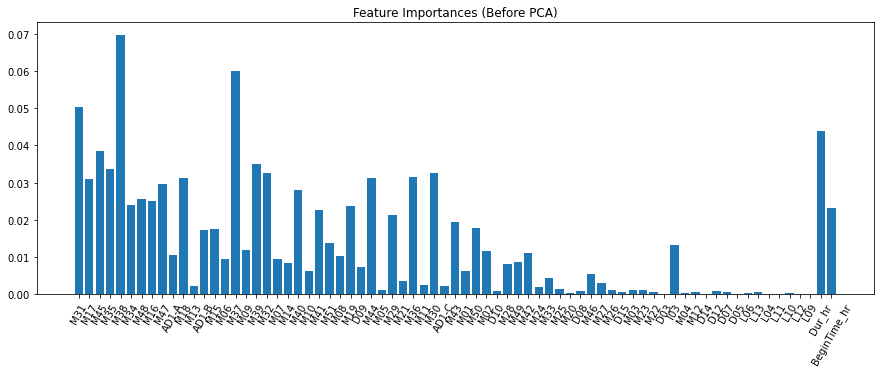

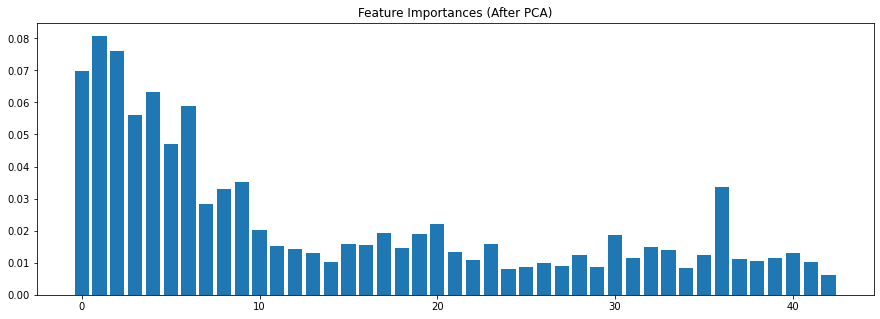

In [11]:
opt=2
final(x_train, y_train,x_test,y_test,opt,0.9999)

In [12]:
opt=3
final(x_train, y_train,x_test,y_test,opt,0.9999)

No PCA:

SVM:

	Training score： 0.9850374064837906
	Validation score： 0.7920792079207921
	Number of right prediction： 80 / 101 . 

{'Recall': 0.77744708994709, 'Accuracy': 0.7920792079207921, 'precision': 0.7749134199134199, 'F1_Score': 0.769983660130719} 

PCA Shape:  (401, 43) (101, 43) 

After PCA:

SVM:

	Training score： 0.9875311720698254
	Validation score： 0.7524752475247525
	Number of right prediction： 76 / 101 . 

{'Recall': 0.72744708994709, 'Accuracy': 0.7524752475247525, 'precision': 0.7252777777777777, 'F1_Score': 0.7184407096171801} 



In [13]:
opt=4
final(x_train, y_train,x_test,y_test,opt,0.9999)

No PCA:

K Neighbors:

	Training score： 0.8403990024937655
	Validation score： 0.7722772277227723
	Number of right prediction： 78 / 101 . 

{'Recall': 0.7450396825396826, 'Accuracy': 0.7722772277227723, 'precision': 0.7501125541125541, 'F1_Score': 0.737087912087912} 

PCA Shape:  (401, 43) (101, 43) 

After PCA:

K Neighbors:

	Training score： 0.8403990024937655
	Validation score： 0.7722772277227723
	Number of right prediction： 78 / 101 . 

{'Recall': 0.7450396825396826, 'Accuracy': 0.7722772277227723, 'precision': 0.7501125541125541, 'F1_Score': 0.737087912087912} 



### Add Up/DownStairs

In [14]:
def Split(df):
    df[["Dur_hr","Dur_min","Dur_sec"]] = df["Duration"].str.split(':', expand=True)
    df[["BeginTime_hr","BeginTime_min","BeginTime_sec"]] = df["BeginTime"].str.split(':', expand=True)

    y=df[['Activity']].values.ravel()
    x=df.drop(['Activity','BeginTime','Duration','Dur_sec','BeginTime_sec','BeginTime_min','Dur_min'],axis=1)
    X,Y=shuffle(x,y)
    x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2, random_state=300)
    return x_train,x_test,y_train,y_test
Df=pd.read_csv('./data2/table_add_ud.csv')
x_train,x_test,y_train,y_test = Split(Df)

In [15]:
df=pd.read_csv('./data2/table_add_ud.csv')
df=df.drop(index=df[df['Activity'].where(df['Activity']=='Study').notnull()==True].index)
df=df.drop(index=df[df['Activity'].where(df['Activity']=='Clean').notnull()==True].index)
df=df.drop(index=df[df['Activity'].where(df['Activity']=='Wash_Bathtub').notnull()==True].index)
x_train,x_test,y_train,y_test = Split(df)

In [16]:
df['Activity'].value_counts()

Meal_Preparation       117
R1_Bed_to_Toilet        60
R1_Work                 58
up&downstairs           46
R1_Personal_Hygiene     45
R2_Work                 43
R2_Bed_to_Toilet        39
R2_Personal_Hygiene     39
R1_Sleep                35
R2_Sleep                35
Watch_TV                31
Name: Activity, dtype: int64

In [17]:
opt=1
final(x_train, y_train,x_test,y_test,opt,0.9999)

No PCA:

Decision Tree:

	Training score： 0.997716894977169
	Validation score： 0.7090909090909091
	Number of right prediction： 78 / 110 . 

{'Recall': 0.7028040141676505, 'Accuracy': 0.7090909090909091, 'precision': 0.7206675899857719, 'F1_Score': 0.6872474942354553} 

PCA Shape:  (438, 43) (110, 43) 

After PCA:

Decision Tree:

	Training score： 0.997716894977169
	Validation score： 0.6454545454545455
	Number of right prediction： 71 / 110 . 

{'Recall': 0.6685261707988981, 'Accuracy': 0.6454545454545455, 'precision': 0.6884758516337464, 'F1_Score': 0.6470123871652892} 



No PCA:

Random Forest:

	Training score： 0.997716894977169
	Validation score： 0.7909090909090909
	Number of right prediction： 87 / 110 . 

{'Recall': 0.7645284008920373, 'Accuracy': 0.7909090909090909, 'precision': 0.82144069149998, 'F1_Score': 0.7712822394145871} 

PCA Shape:  (438, 43) (110, 43) 

After PCA:

Random Forest:

	Training score： 0.997716894977169
	Validation score： 0.8090909090909091
	Number of right prediction： 89 / 110 . 

{'Recall': 0.8045749704840613, 'Accuracy': 0.8090909090909091, 'precision': 0.8424173981486235, 'F1_Score': 0.8075771037677495} 



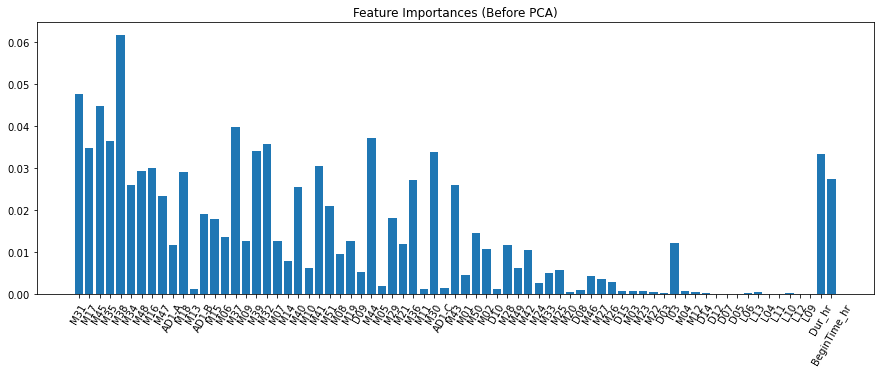

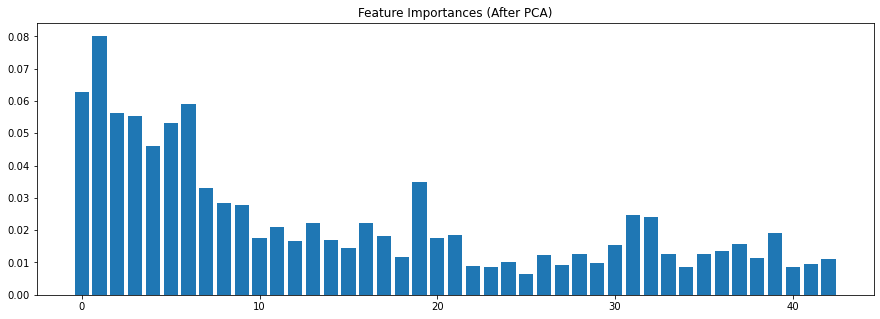

In [18]:
opt=2
final(x_train, y_train,x_test,y_test,opt,0.9999)

In [19]:
opt=3
final(x_train, y_train,x_test,y_test,opt,0.9999)

No PCA:

SVM:

	Training score： 0.9908675799086758
	Validation score： 0.8090909090909091
	Number of right prediction： 89 / 110 . 

{'Recall': 0.7937131050767413, 'Accuracy': 0.8090909090909091, 'precision': 0.8351993965630328, 'F1_Score': 0.799631687590382} 

PCA Shape:  (438, 43) (110, 43) 

After PCA:

SVM:

	Training score： 0.9863013698630136
	Validation score： 0.8090909090909091
	Number of right prediction： 89 / 110 . 

{'Recall': 0.7885182998819361, 'Accuracy': 0.8090909090909091, 'precision': 0.8147448511084875, 'F1_Score': 0.7956154486459134} 



In [20]:
opt=4
final(x_train, y_train,x_test,y_test,opt,0.9999)

No PCA:

K Neighbors:

	Training score： 0.8082191780821918
	Validation score： 0.8
	Number of right prediction： 88 / 110 . 

{'Recall': 0.7838351042896498, 'Accuracy': 0.8, 'precision': 0.857608802110081, 'F1_Score': 0.7962099055893891} 

PCA Shape:  (438, 43) (110, 43) 

After PCA:

K Neighbors:

	Training score： 0.8082191780821918
	Validation score： 0.8
	Number of right prediction： 88 / 110 . 

{'Recall': 0.7838351042896498, 'Accuracy': 0.8, 'precision': 0.857608802110081, 'F1_Score': 0.7962099055893891} 



In [21]:
# reset